# Bayesian CNN

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

%matplotlib inline
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys
from numpy import load
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.models import Model
from tensorflow.keras import regularizers
from keras.applications.inception_v3 import InceptionV3, preprocess_input

#

In [2]:
import pandas as pd 
train_Y = pd.read_csv('/90days/s4634945/files/UntitledFolder/Cluster_Img_trial.csv')
train_Y['Sno'] = train_Y['Sno'].astype('str') + str(".png")
train_Y['Cluster'] = train_Y['Cluster'].astype('str')
test_Y = pd.read_csv('/90days/s4634945/files/UntitledFolder/Cluter_Img2.csv')
test_Y['Cluster'] = test_Y['Cluster'].replace({2:0})
test_Y = test_Y.sort_values(by='Sno')
test_Y = test_Y.reset_index(drop=True)
test_Y['Sno'] = test_Y['Sno'].astype('str') + str(".png")
test_Y['Cluster'] = test_Y['Cluster'].astype('str')



datagen=ImageDataGenerator(rescale=1./255, validation_split = 0.2, featurewise_center=True,
            featurewise_std_normalization=False,
            rotation_range=90,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255,featurewise_center=True)




###########       Replace the Image files here, the code remains same.        ########### 
train_generator=datagen.flow_from_dataframe(dataframe=train_Y, directory="/90days/s4634945/files/UntitledFolder/K_2_breast_train299", 
                                            x_col="Sno", y_col="Cluster", class_mode="categorical", 
                                            target_size=(290,290), batch_size=32, subset="training")
valid_generator = datagen.flow_from_dataframe(dataframe=train_Y, directory="/90days/s4634945/files/UntitledFolder/K_2_breast_train299", 
                                              x_col="Sno", y_col="Cluster", class_mode="categorical", 
                                              target_size=(290,290), batch_size=32, subset="validation")
test_generator = test_datagen.flow_from_dataframe(dataframe=test_Y, directory="/90days/s4634945/files/UntitledFolder/Trainimg_breast_test_299", 
                                                  x_col="Sno", y_col="Cluster", class_mode="categorical", 
                                                  target_size=(290,290), batch_size=32)

Found 3039 validated image filenames belonging to 2 classes.
Found 759 validated image filenames belonging to 2 classes.


#

In [3]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/3798

model_bayes = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(290,290,3), filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(2), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(2)
    
])
model_bayes.summary()

/90days/s4634945/.conda/envs/myenv/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization (C (None, 275, 275, 8)       12304     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 137, 137, 8)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 135, 135, 32)      2336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 67, 67, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 65, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        3

In [4]:
from tensorflow.keras.optimizers import Adam

def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.005),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [5]:
history_bayes = model_bayes.fit(
      train_generator,
      validation_data=valid_generator,
      epochs=3,
      verbose=1)

/90days/s4634945/.conda/envs/myenv/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/3
95/95 [==============================] - 382s 4s/step - loss: 8.8200 - accuracy: 0.5079 - val_loss: 5.0094 - val_accuracy: 0.5086
Epoch 2/3
95/95 [==============================] - 365s 4s/step - loss: 4.8842 - accuracy: 0.4902 - val_loss: 4.5304 - val_accuracy: 0.5165
Epoch 3/3
95/95 [==============================] - 361s 4s/step - loss: 4.4217 - accuracy: 0.5073 - val_loss: 4.1397 - val_accuracy: 0.5296


#

# LIME

#

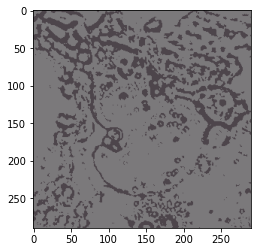

In [21]:
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(290, 290))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)
import os
from keras.applications.imagenet_utils import decode_predictions
images = transform_img_fn([os.path.join('/90days/s4634945/files/UntitledFolder/K_2_breast_train299','0001img.png')])
plt.imshow(images[0])
preds = model_bayes.predict(images)

In [22]:
%%time
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), model_bayes.predict, top_labels=2, hide_color=0, num_samples=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 1.74 s, sys: 11.3 ms, total: 1.75 s
Wall time: 1.5 s


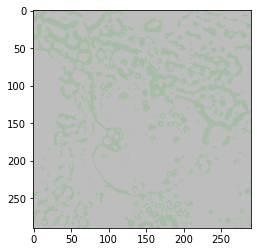

In [26]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=100, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [24]:
explanation.top_labels[0]

1

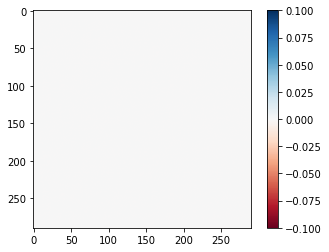

In [25]:
ind =  explanation.top_labels[0]
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# Transfer Learning Normal Images

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys
from numpy import load
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.models import Model
from tensorflow.keras import regularizers
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [ ]:
import pandas as pd 
train_Y = pd.read_csv('/90days/s4634945/files/UntitledFolder/Cluster_Img_trial.csv')
train_Y['Sno'] = train_Y['Sno'].astype('str') + str(".tif")
train_Y['Cluster'] = train_Y['Cluster'].astype('str')
test_Y = pd.read_csv('/90days/s4634945/files/UntitledFolder/Cluter_Img2.csv')
test_Y['Cluster'] = test_Y['Cluster'].replace({2:0})
test_Y = test_Y.sort_values(by='Sno')
test_Y = test_Y.reset_index(drop=True)
test_Y['Sno'] = test_Y['Sno'].astype('str') + str(".tif")
test_Y['Cluster'] = test_Y['Cluster'].astype('str')



datagen=ImageDataGenerator(rescale=1./255, validation_split = 0.2, featurewise_center=True,
            featurewise_std_normalization=False,
            rotation_range=90,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255,featurewise_center=True)



######   Replace Images with K-Means if needed     ######
train_generator=datagen.flow_from_dataframe(dataframe=train_Y, directory="/90days/s4634945/files/UntitledFolder/Trainimg_breast_2_299", 
                                            x_col="Sno", y_col="Cluster", class_mode="categorical", 
                                            target_size=(290,290), batch_size=32, subset="training")
valid_generator = datagen.flow_from_dataframe(dataframe=train_Y, directory="/90days/s4634945/files/UntitledFolder/Trainimg_breast_2_299", 
                                              x_col="Sno", y_col="Cluster", class_mode="categorical", 
                                              target_size=(290,290), batch_size=32, subset="validation")
test_generator = test_datagen.flow_from_dataframe(dataframe=test_Y, directory="/90days/s4634945/files/UntitledFolder/Trainimg_breast_test_299", 
                                                  x_col="Sno", y_col="Cluster", class_mode="categorical", 
                                                  target_size=(290,290), batch_size=32)

In [ ]:
model = InceptionV3(include_top=False, input_shape=(290,290,3), weights = "imagenet")
flat1 = Flatten()(model.layers[-1].output)
dense = Dense(256, activation='relu')(flat1)
drop = Dropout(0.5)(dense)
output = Dense(2, activation='softmax')(drop)
model = Model(inputs=model.inputs, outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_generator,validation_data=valid_generator,epochs=5)

# Test Set

In [ ]:
print(model.evaluate(test_generator))
#from skimage import io
from tensorflow.keras.preprocessing import image
import cv2
import glob
preds = model.predict(test_generator)
test_pred = np.argmax(preds, axis=1)
#print(test_pred)
unique, counts = np.unique(test_pred, return_counts=True)
print(counts)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

preds = model.predict(test_generator)
test_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(df_test['Cluster'].astype('int64'), test_pred)
print('Confusion matrix\n\n', cm)
classifier_report = classification_report(df_test['Cluster'].astype('int64'), test_pred)
print(classifier_report)
multiclass_roc_score = multiclass_roc_auc_score(df_test['Cluster'].astype('int64'), test_pred, average="weighted")
print("Multiclass_roc_score")
print(multiclass_roc_score)
logloss = log_loss(df_test['Cluster'].astype('int64'), preds)
print(logloss)